# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session 1B: More Basic Concepts

This notebook begins by revisiting the laplacian example from the previous session, only this time with a GPU!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

try:
    import cupy as cp
except ImportError:
    cp = None

import gt4py
import gt4py.storage as gt_storage
from gt4py import gtscript
from gt4py.gtscript import Field

In [2]:
def laplacian_def(in_field: Field[np.float64], out_field: Field[np.float64], *, coeff: float):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

In [3]:
ni, nj, nk = 24, 24, 79
nhalo = 3
nruns = 5

In [4]:
backends = ["numpy", "gtmc", "gtcuda"]
timings = dict()
sizes = dict()

for backend in backends:
    ni = nj = 24
    sizes[backend] = []
    timings[backend] = []    

    for n in range(0, nruns):
        print(f"Running with {backend} backend ({n})...")

        origin = (nhalo, nhalo, 0)
        shape = (ni + 2*nhalo, nj + 2*nhalo, nk)
        rand_data = np.random.randn(*shape)
        in_field = gt_storage.from_array(rand_data, backend, origin, shape, dtype=np.float64)        
        out_field = gt_storage.zeros(backend, origin, shape, np.float64)        

        laplacian = gtscript.stencil(backend, laplacian_def)  # , rebuild=False)
        
        fields = {"in_field": in_field, "out_field": out_field}
        scalars = {"coeff": 0.125}
        exec_info = {}
        
        laplacian(**fields, **scalars, origin=origin, domain=(ni, nj, nk), exec_info=exec_info, validate_args=False)
        
        call_time = (exec_info['call_end_time']-exec_info['call_start_time']) * 1000.
        run_time = (exec_info['run_end_time']-exec_info['run_start_time']) * 1000.        
        timings[backend].append(run_time)
        sizes[backend].append(ni)

        ni *= 2
        nj = ni

        print(f"  call_time = {call_time} ms")
        print(f"  run_time = {run_time} ms")
        print(f"  overhead = {(call_time - run_time)} ms")
        print("")


Running with numpy backend (0)...
  call_time = 1.2494299990066793 ms
  run_time = 1.0051190001831856 ms
  overhead = 0.24431099882349372 ms

Running with numpy backend (1)...
  call_time = 1.4611089991376502 ms
  run_time = 1.2917000003653811 ms
  overhead = 0.16940899877226911 ms

Running with numpy backend (2)...
  call_time = 7.298630000150297 ms
  run_time = 7.075652998537407 ms
  overhead = 0.22297700161288958 ms

Running with numpy backend (3)...
  call_time = 28.73416300099052 ms
  run_time = 28.456420001020888 ms
  overhead = 0.27774299996963236 ms

Running with numpy backend (4)...
  call_time = 118.6473540001316 ms
  run_time = 118.36103700079548 ms
  overhead = 0.28631699933612254 ms

Running with gtmc backend (0)...
  call_time = 2.8527230006147875 ms
  run_time = 2.6499609994061757 ms
  overhead = 0.20276200120861176 ms

Running with gtmc backend (1)...
  call_time = 0.3414210004848428 ms
  run_time = 0.13617500007967465 ms
  overhead = 0.20524600040516816 ms

Running wit

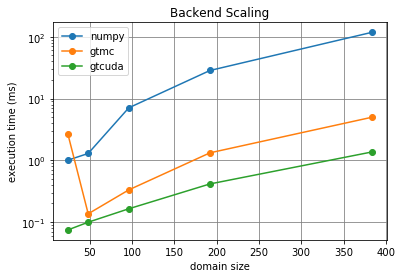

In [5]:
for backend in backends:
    plt.plot(sizes[backend], timings[backend], "-o", label=backend)

plt.title("Backend Scaling")
plt.grid(color="gray", linestyle='-')
plt.legend()
plt.xlabel("domain size")
plt.ylabel("execution time (ms)")
plt.yscale("log")

plt.show()

In [25]:
FloatField = Field[np.float64]
FloatFieldIJ = Field[np.float64, gtscript.IJ]
IntFieldIJ = Field[np.int64, gtscript.IJ]

@gtscript.stencil(backend="numpy")
def counts_and_sums(
    q: FloatField,
    dp: FloatField,
    dm: FloatField,    
    zfix: IntFieldIJ,    
    zsum: FloatFieldIJ,    
):
    with computation(PARALLEL), interval(...):
        zfix = 0
        zsum = 0.0
    with computation(FORWARD), interval(1, -1):
        if (q < 0.0) and (q[0, 0, -1] > 0.0):
            zfix += 1
            q += (q[0, 0, -1] * dp[0, 0, -1]) / dp
        dm = q * dp        
    with computation(FORWARD), interval(1, None):
        zsum += dm
        if zfix > 0:
            q = zsum * dm / dp if zsum * dm / dp > 0.0 else 0.0

In [38]:
itype = np.int
IntFieldK = Field[itype, gtscript.K]
backend = "numpy"


@gtscript.stencil(backend=backend)
def fibonacci(fib: IntFieldK):    
    with computation(FORWARD), interval(2, None):
        fib = fib[0, 0, -2] + fib[0, 0, -1]
        

fib_field = gt_storage.zeros(backend, (0, 0, 0), (1, 1, 64), itype)
fib_field[0, 0, 1] = 1    # base case...

fibonacci(fib_field, origin=(0, 0, 0), domain=(1, 1, 64), validate_args=False)
fib_field

CPUStorage([[[            0,             1,             1,
                          2,             3,             5,
                          8,            13,            21,
                         34,            55,            89,
                        144,           233,           377,
                        610,           987,          1597,
                       2584,          4181,          6765,
                      10946,         17711,         28657,
                      46368,         75025,        121393,
                     196418,        317811,        514229,
                     832040,       1346269,       2178309,
                    3524578,       5702887,       9227465,
                   14930352,      24157817,      39088169,
                   63245986,     102334155,     165580141,
                  267914296,     433494437,     701408733,
                 1134903170,    1836311903,    2971215073,
                 4807526976,    7778742049,   1258626902

In [75]:
backend = "gtmc"
dtype = np.float64
Field3D = Field[dtype]
Field2D = Field[dtype, gtscript.IJ]


@gtscript.stencil(backend=backend)
def parallel_sum(nums: Field3D, sums: Field2D):
    with computation(PARALLEL), interval(...):
        sums += nums
        

in_data = np.fromfunction(lambda i, j, k: np.sin(i) * np.cos(j), (64, 64, 64), dtype=dtype)
nums = gt_storage.from_array(in_data, backend, (0, 0, 0), (64, 64, 64), dtype=dtype)  
sums = gt_storage.zeros(backend, (0, 0, 0), (64, 64, 1), dtype)

parallel_sum(nums, sums, origin=(0, 0, 0), domain=(64, 64, 64), validate_args=False)

sums[:, :, 0]

CPUStorage([[  0.        ,   0.        ,   0.        , ...,   0.        ,
               0.        ,   0.        ],
            [ 53.85414303,  29.09751766, -22.41123126, ..., -13.89984242,
              36.27115105,  53.09461552],
            [ 58.19503532,  31.44291177, -24.21767985, ..., -15.02023382,
              39.1947731 ,  57.37428638],
            ...,
            [-61.83153728, -33.40772217,  25.73099864, ...,  15.95882092,
             -41.64398322, -60.95950124],
            [-47.30756459, -25.56038623,  19.68689335, ...,  12.21015981,
             -31.86198358, -46.64036621],
            [ 10.71076482,   5.78705093,  -4.4572509 , ...,  -2.76446592,
               7.21377682,  10.55970642]])

In [95]:
backend = "gtmc"
dtype = np.float64
itype = np.int32
Field3D = Field[dtype]
IntField2D = Field[itype, gtscript.IJ]


@gtscript.stencil(backend=backend)
def parallel_count(nums: Field3D, counts: IntField2D):
    with computation(PARALLEL), interval(...):
        if nums > 0.0:
            counts += 1
        

in_data = np.fromfunction(lambda i, j, k: np.sin(i) * np.cos(j), (64, 64, 64), dtype=dtype)
nums = gt_storage.from_array(in_data, backend, (0, 0, 0), (64, 64, 64), dtype=dtype)  
counts = gt_storage.zeros(backend, (0, 0, 0), (64, 64, 1), itype)

parallel_count(nums, counts, origin=(0, 0, 0), domain=(64, 64, 64), validate_args=False)

counts[:, :, 0]

CPUStorage([[ 0,  0,  0, ...,  0,  0,  0],
            [64, 64,  0, ...,  0, 64, 64],
            [64, 64,  0, ...,  0, 64, 64],
            ...,
            [ 0,  0, 64, ..., 64,  0,  0],
            [ 0,  0, 64, ..., 64,  0,  0],
            [64, 64,  0, ...,  0, 64, 64]], dtype=int32)

In [140]:
backend = "numpy"
dtype = np.float64
Field3D = Field[dtype]
N = 1024

@gtscript.stencil(backend=backend)
def tridiag_mv_mul(a: Field3D, b: Field3D, c: Field3D, d: Field3D, x: Field3D):
    with computation(PARALLEL):
        with interval(0, 1):
            d = b * x + c * x[0, 0, 1]
        with interval(1, -1):
            d = a * x[0, 0, -1] + b * x + c * x[0, 0, 1]
        with interval(-1, None):
            d = a * x[0, 0, -1] + b * x

@gtscript.stencil(backend=backend)        
def tridiag_solve(a: Field3D, b: Field3D, c: Field3D, d: Field3D, x: Field3D):
    with computation(FORWARD):
        with interval(1, None):
            w = a / b[0, 0, -1]
            b -= w * c[0, 0, -1]
            d -= w * d[0, 0, -1]
    with computation(BACKWARD):
        with interval(-1, None):
            x = d / b
        with interval(0, -1):
            x = (d - c * x[0, 0, 1]) / b


origin = (0, 0, 0)
shape = (1, 1, N)
a = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
b = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
c = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
x0 = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
d = gt_storage.zeros(backend, origin, shape, dtype=dtype)
x1 = gt_storage.zeros(backend, origin, shape, dtype=dtype)

tridiag_mv_mul(a, b, c, d, x0)
tridiag_solve(a, b, c, d, x1)
assert np.allclose(x0, x1)
x1[0, 0, :]

CPUStorage([-0.676337  ,  1.01069665,  0.1619976 , ...,  0.57317459,
            -1.05411054, -0.1779109 ])